In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, ResNet101_Weights
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import torchvision.transforms as T

import numpy as np
from sklearn.manifold import TSNE
import os 
    

In [3]:

LARGE_NUM = 1e9

In [4]:
from datasets import load_dataset,DatasetDict

ds = load_dataset("jonathan-roberts1/EuroSAT")

README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

In [5]:
split_ratio = 0.2
data_splits = ds['train'].train_test_split(test_size=split_ratio,seed=42)
ds=DatasetDict({
    'train':data_splits['train'],
    'validation':data_splits['test']
})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})


In [6]:
testpicture = ds['train'][5]['image']
width, height = testpicture.size
print(f"Dimensions: {width}x{height}")
rgb_values = testpicture.getpixel((0, 0))
print(f"RGB values of top-left pixel: {rgb_values}")
pixels = np.array(testpicture)

print("Pixel array shape:", pixels.shape)

Dimensions: 64x64
RGB values of top-left pixel: (48, 75, 94)
Pixel array shape: (64, 64, 3)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

For RGB images: (height, width, 3) (the last dimension represents the three color channels: Red, Green, and Blue).
For grayscale images: (height, width) (no color channels).Iterating Over Pixels: If you need to process each pixel individually, you can loop through image.getpixel((x, y)), but this can be slow. Using numpy for pixel manipulation is generally faster.

In [8]:
# Loss
def nt_xent(z: torch.Tensor, perm: torch.Tensor, tau: float) -> torch.Tensor:

    features = F.normalize(z, dim=1)
    sim = features @ features.T 
    sim.fill_diagonal_(-LARGE_NUM)
    sim /= tau
    return F.cross_entropy(sim, perm)

In [9]:

class SimCLRDataset(Dataset):
    """
    Dataset class for SimCLR
    """
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]

        # Generate two augmented views
        view1 = self.transform(image)
        view2 = self.transform(image)

        return view1, view2

In [10]:
def compute_mean_std(dataset):

    transform = T.ToTensor()  
    # Converting images to PyTorch tensors
    mean = torch.zeros(3) 
    # For RGB channels
    std = torch.zeros(3)
    total_pixels = 0

    for sample in dataset:
        image = transform(sample['image'])  
        # Converting image to tensor
        total_pixels += image.size(1) * image.size(2)  
        # H x W
        mean += image.sum(dim=[1, 2]) 
        # Summing over H and W for each channel
        std += (image ** 2).sum(dim=[1, 2])  
        # Sum of squares over H and W

    mean /= total_pixels 
    # Computing mean
    std = torch.sqrt(std / total_pixels - mean ** 2) 
    # Computing std

    return mean.tolist(), std.tolist()

In [11]:
mean, std = compute_mean_std(ds['train'])
print("Mean:", mean)
print("Std:", std)

Mean: [0.3440585732460022, 0.38018861413002014, 0.4077899754047394]
Std: [0.20264330506324768, 0.13694031536579132, 0.11556307226419449]


In [12]:
# DataLoader
simclr_transforms = T.Compose([
    T.RandomResizedCrop(size=64),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.2)],p=0.2),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    # T.Normalize(mean=[0.344, 0.380, 0.407], std=[0.203, 0.136, 0.114])
    #to ensure that the data stays around 0
])

size=64

euroSAT_transforms = T.Compose([
            T.RandomResizedCrop(size=(size, size), scale=(0.7, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2, hue=0.2),
            # T.RandomRotation(degrees=30),
            # T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
            T.ToTensor(),
            # T.Normalize(mean=mean, std=std)
])

small_test_transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

# Reasons for keeping the above augmentations 
 - RandomResizedCrop - it forces the model to learn spatial invariance, even if parts of the image are cropped out, model should recognize it as the same instance.forces the model to focus on overall structure rather than specific regions.
 - RandomHorizontalFlip and RandomVerticalFlip- we don't want the model to rely much on directionality
 - ColorJitter - Simulates changes in lighting and color conditions. foreces the model to learn shape and structure instead of color.


In [13]:
test_image = ds['train'][8]['image']
v1 = simclr_transforms(test_image)
v2 = simclr_transforms(test_image)
view1 = euroSAT_transforms(test_image)
view2 = euroSAT_transforms(test_image)

v1i = T.ToPILImage()(v1)
v2i = T.ToPILImage()(v2)
view1i = T.ToPILImage()(view1)
view2i = T.ToPILImage()(view2)

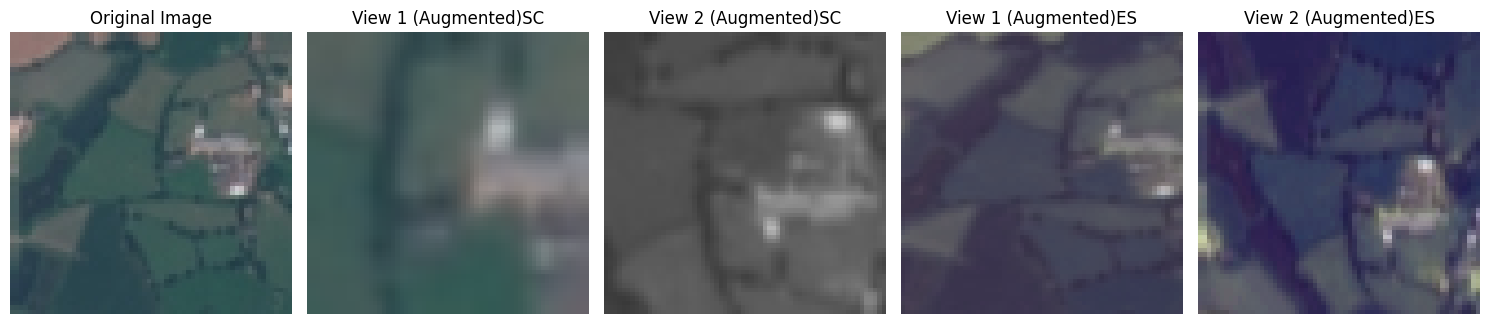

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(test_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(v1i)
axes[1].set_title("View 1 (Augmented)SC")
axes[1].axis("off")

axes[2].imshow(v2i)
axes[2].set_title("View 2 (Augmented)SC")
axes[2].axis("off")

axes[3].imshow(view1i)
axes[3].set_title("View 1 (Augmented)ES")
axes[3].axis("off")

axes[4].imshow(view2i)
axes[4].set_title("View 2 (Augmented)ES")
axes[4].axis("off")

plt.tight_layout()
plt.show()

In [15]:

class SimCLR(nn.Module):

    def __init__(self, backbone: nn.Module, tau: float, feat_dim: int = 256):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.tau = tau

        # Define the projection head
        z_dim = self.backbone.fc.in_features
        # Remove the classification head
        self.backbone.fc = nn.Identity()  
        
        self.projection_head = nn.Sequential(
            nn.Linear(z_dim, z_dim, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(z_dim, feat_dim, bias=False)
        )

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:

        b = x1.size(0)

        # (2b, c, h, w)
        xp = torch.cat((x1, x2))  

        # Permutation for positive pairs
        perm = torch.cat((torch.arange(b) + b, torch.arange(b)), dim=0).to(x1.device)
        # (2b, z_dim)
        h = self.backbone(xp) 
        # (2b, feat_dim)
        z = self.projection_head(h)  

        return nt_xent(z, perm, tau=self.tau)
    def encode(self, x: torch.Tensor) -> torch.Tensor:

        self.eval()
        with torch.no_grad():
            # (B, z_dim)
            h = self.backbone(x)
            # (B, feat_dim)
            z = self.projection_head(h)
        return z

In [16]:


train_dataset = SimCLRDataset(ds['train'],transform=euroSAT_transforms)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = SimCLRDataset(ds['validation'],transform=euroSAT_transforms)
val_loader = DataLoader(val_dataset,batch_size=512,shuffle=False)




In [19]:

backbone = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
model = SimCLR(backbone=backbone, tau=0.1).to(device)
# model.load_state_dict(torch.load('/kaggle/input/simclr_model2/pytorch/v1/1/simclr_model2.pth',weights_only=True))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 201MB/s] 


In [18]:
# subset_indices = list(range(100))
# small_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
# small_loader = DataLoader(small_dataset, batch_size=64, shuffle=True)

In [19]:
# model.train()
# for epoch in range(100):  # Fewer epochs for overfitting test
    
#     epoch_loss = 0
#     for step, (x1, x2) in enumerate(small_loader):
#         x1, x2 = x1.to(device), x2.to(device)
#         loss = model(x1, x2)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Tiny Dataset Epoch [{epoch + 1}/100], Loss: {epoch_loss:.4f}")

In [20]:
tsne_logs_path = "/kaggle/working/tsne_logs"
os.makedirs(tsne_logs_path, exist_ok=True)
val_labels_all = []

In [21]:
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for step, (x1, x2) in enumerate(train_loader):
        x1, x2 = x1.to(device), x2.to(device)
        loss = model(x1, x2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
    model.eval()
    val_loss = 0
    backbone_features = []
    val_labels = []
    
    with torch.no_grad():
        for step,(x1,x2) in enumerate(val_loader):
            x1 = x1.to(device)
            features = model.backbone(x1)
            backbone_features.append(features.cpu())
            if hasattr(val_loader.dataset, "labels"):
                val_labels.append(val_loader.dataset.labels[step * x1.size(0):(step + 1) * x1.size(0)])
            x2 = x2.to(device)
            loss = model(x1,x2)
            val_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss : {val_loss/len(val_loader):.4f}")
    all_feats = torch.cat(backbone_features, dim=0)
    if len(val_labels) > 0:
        all_labels = torch.cat(val_labels, dim=0).numpy()
    else:
        all_labels = np.zeros(all_feats.shape[0])  # Dummy labels

    tsne = TSNE(n_components=2, perplexity=30, init='random', learning_rate='auto')
    tsne_result = tsne.fit_transform(all_feats.numpy())

    # Save embeddings and labels for animation later
    np.save(os.path.join(tsne_logs_path, f"epoch_{epoch}_embeddings.npy"), tsne_result)
    np.save(os.path.join(tsne_logs_path, f"epoch_{epoch}_labels.npy"), all_labels)

Epoch [1/100], Loss: 2.2806
Epoch [1/100], Validation Loss : 1.3554
Epoch [2/100], Loss: 1.0198
Epoch [2/100], Validation Loss : 0.8818
Epoch [3/100], Loss: 0.7657
Epoch [3/100], Validation Loss : 0.7329
Epoch [4/100], Loss: 0.6879
Epoch [4/100], Validation Loss : 0.7787
Epoch [5/100], Loss: 0.6299
Epoch [5/100], Validation Loss : 0.6046
Epoch [6/100], Loss: 0.5513
Epoch [6/100], Validation Loss : 0.5663
Epoch [7/100], Loss: 0.5234
Epoch [7/100], Validation Loss : 0.5354
Epoch [8/100], Loss: 0.5027
Epoch [8/100], Validation Loss : 0.5225
Epoch [9/100], Loss: 0.4760
Epoch [9/100], Validation Loss : 0.4839
Epoch [10/100], Loss: 0.4735
Epoch [10/100], Validation Loss : 0.6101
Epoch [11/100], Loss: 0.4810
Epoch [11/100], Validation Loss : 0.4716
Epoch [12/100], Loss: 0.4461
Epoch [12/100], Validation Loss : 0.4493
Epoch [13/100], Loss: 0.4279
Epoch [13/100], Validation Loss : 0.4728
Epoch [14/100], Loss: 0.4140
Epoch [14/100], Validation Loss : 0.4218
Epoch [15/100], Loss: 0.3960
Epoch [15

In [34]:
# import os
# save_dir = "/kaggle/working/"
# os.makedirs(save_dir, exist_ok=True)
# model_save_path = os.path.join(save_dir, "simclr_model_RN101.pth")
# torch.save(model.state_dict(), model_save_path)

# print(f"Model saved to {model_save_path}")
# torch.save(model, os.path.join(save_dir, "simclr_full_model_RN101.pth"))

Model saved to /kaggle/working/simclr_model2.pth


In [22]:
# import os
# save_dir = "/kaggle/working/"
# model_save_path = os.path.join(save_dir, "simclr_model3.pth")
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")
# torch.save(model, os.path.join(save_dir, "simclr_full_model3.pth"))

Model saved to /kaggle/working/simclr_model3.pth


In [22]:
import os
save_dir = "/kaggle/working/"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "simclr_model_RN101.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")
torch.save(model, os.path.join(save_dir, "simclr_full_model_RN101.pth"))

Model saved to /kaggle/working/simclr_model_RN101.pth


In [23]:
import matplotlib.animation as animation
from matplotlib.cm import get_cmap

In [24]:
train_dataset = ds['train']
if hasattr(train_dataset.features['label'], 'names'):
    class_names = train_dataset.features['label'].names
    print(f"Class names: {class_names}")
else:
    print("No class names found. Labels might be integers.")
num_classes = len(class_names)

Class names: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']


In [25]:
tsne_logs_path = '/kaggle/working/tsne_logs'

cmap = get_cmap('tab20')

/tmp/ipykernel_25/2294716883.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


GIF saved to /kaggle/working/genre_tsne.gif


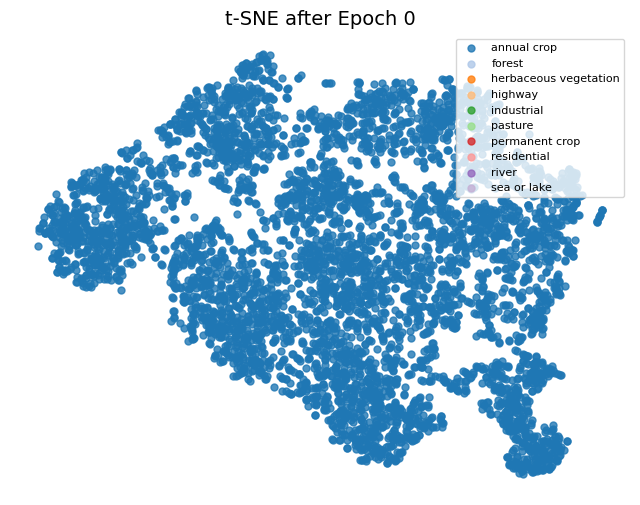

In [26]:
tsne_results = []
label_sample = None

for fname in sorted(os.listdir(tsne_logs_path)):
    if fname.startswith("epoch_") and fname.endswith("embeddings.npy"):
        epoch = int(fname.split('_')[1])
        embed_path = os.path.join(tsne_logs_path, fname)
        label_path = embed_path.replace("embeddings.npy", "labels.npy")
        
        embeddings = np.load(embed_path)
        labels = np.load(label_path)
        
        if label_sample is None:
            label_sample = labels
        tsne_results.append((epoch, embeddings, labels))

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    epoch, embeddings, labels = tsne_results[frame]
    
    for i in range(num_classes):
        idxs = labels == i
        ax.scatter(embeddings[idxs, 0], embeddings[idxs, 1], 
                   label=class_names[i], s=25, alpha=0.8, color=cmap(i % cmap.N))
    
    ax.set_title(f't-SNE after Epoch {epoch}', fontsize=14)
    ax.legend(loc='upper right', fontsize=8)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results), interval=1000)
ani.save('/kaggle/working/genre_tsne.gif', writer='pillow')
print("GIF saved to /kaggle/working/genre_tsne.gif")

In [27]:

print(f"Type of saved data: {type(model)}")
if isinstance(model, dict):
    print("Keys in the checkpoint:")
    print(model.keys())

    # If it has a `state_dict` key, inspect model weights
    if "state_dict" in model:
        print("Model state_dict keys:")
        print(model["state_dict"].keys())
else:
    print("Model or other saved object:")

Type of saved data: <class '__main__.SimCLR'>
Model or other saved object:


In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

In [29]:
model.eval()
def extract_features(loader,model,device):
    features = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            images,targets = batch 
            images = images.to(device)
            embeddings = model.backbone(images)
            features.append(embeddings.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features,axis=0)
    labels = np.concatenate(labels,axis=0)
    return features,labels

In [30]:
features,labels = extract_features(val_loader,model,device)
labels = np.array(ds['validation']['label'])  # This should give a 1D array

In [31]:
print(f"Features shape: {features.shape}")  # Should be (num_samples, 2) for t-SNE
print(f"Labels shape: {labels.shape}")  

Features shape: (5400, 2048)
Labels shape: (5400,)


In [32]:
tsne = TSNE(n_components = 2, perplexity = 30,random_state=42,n_iter=1000)
reduced_features = tsne.fit_transform(features)

In [33]:
def plot_tsne(features, labels, class_names):
    plt.figure(figsize=(10, 8))
    
    # Plot each class with a unique color
    for class_id in np.unique(labels):
        idx = (labels == class_id)  # Boolean mask
        plt.scatter(features[idx, 0], features[idx, 1], label=class_names[class_id], alpha=0.6, s=10)
    
    plt.legend()
    plt.title("t-SNE Visualization of SimCLR Embeddings")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()


In [34]:
train_dataset = ds['train']
if hasattr(train_dataset.features['label'], 'names'):
    class_names = train_dataset.features['label'].names
    print(f"Class names: {class_names}")
else:
    print("No class names found. Labels might be integers.")

Class names: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']


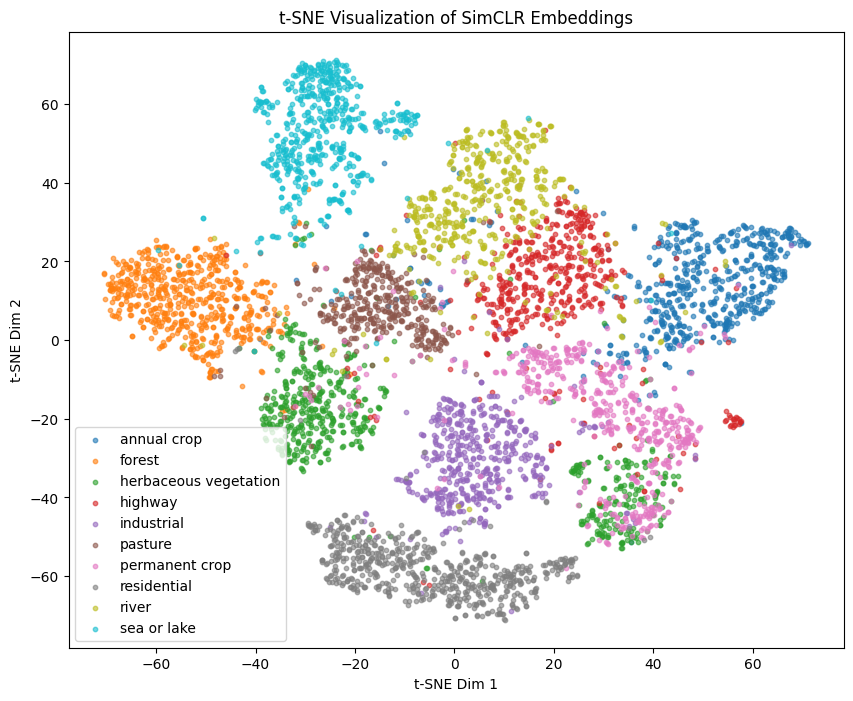

In [35]:
plot_tsne(reduced_features,labels,class_names)

![](http://)

## There's ambiguity when it comes to 
- herbaceous vegetation and permanent crop - maybe because the representations for these classes are not far apart ? 

- Is it possible that the augmentations are making some distinct classes look similar ?
-  For example is there any difference in texture between herbaceous vegetation and permanent crop 

- satellite images often emphasize channel specific information like vegetation indices like NDVI and stuff making grayscale less relevant for feature extraction. 

## What are the distinguishing features in ambiguous classes ?

6


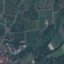

In [26]:
#Class names: ['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake']
print(ds['train'][78]['label'])
ds['train'][78]['image']

In [27]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})

Samples from Herbaceous vegetation:


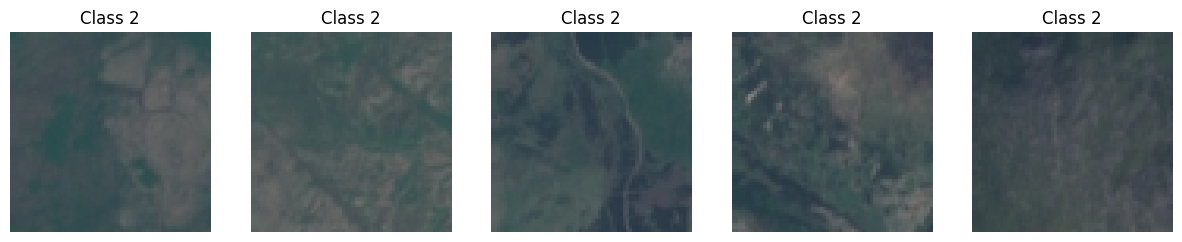

Samples from Permanent Crop


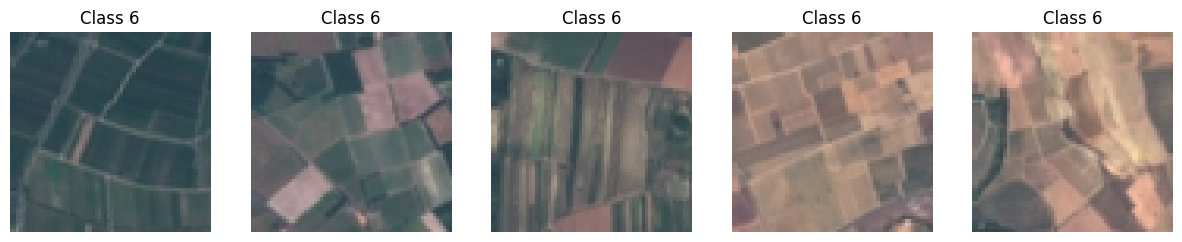

In [16]:
def show_samples(ds, class_label, num_samples=5):
    samples = [example for example in ds['train'] if example['label'] == class_label][:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for idx, sample in enumerate(samples):
        axes[idx].imshow(sample['image'])
        axes[idx].set_title(f"Class {class_label}")
        axes[idx].axis("off")
    plt.show()

print("Samples from Herbaceous vegetation:")
show_samples(ds, class_label=2)

print("Samples from Permanent Crop")
show_samples(ds, class_label=6)

In [47]:
!zip -r /kaggle/working/zipped_tsne.zip /kaggle/working/tsne_logs

  adding: kaggle/working/tsne_logs/ (stored 0%)
  adding: kaggle/working/tsne_logs/epoch_98_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_46_labels.npy (deflated 100%)
  adding: kaggle/working/tsne_logs/epoch_79_labels.npy (deflated 100%)
  adding: kaggle/working/tsne_logs/epoch_68_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_96_embeddings.npy (deflated 8%)
  adding: kaggle/working/tsne_logs/epoch_38_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_15_labels.npy (deflated 100%)
  adding: kaggle/working/tsne_logs/epoch_5_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_34_labels.npy (deflated 100%)
  adding: kaggle/working/tsne_logs/epoch_62_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_32_embeddings.npy (deflated 7%)
  adding: kaggle/working/tsne_logs/epoch_54_labels.npy (deflated 100%)
  adding: kaggle/working/tsne_logs/epoch_51_labels.npy (deflated 100%)
  adding: kaggle

In [36]:
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name)
    param.requires_grad = False
print("Params don't require gradient now")
    

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer1.1.conv3.weight
backbone.layer1.1.bn3.weight
backbone.layer1.1.bn3.bias
backbone.layer1.2.conv1.weight
backbone.layer1.2.bn1.weight
backbone.layer1.2.bn1.bias
backbone.layer1.2.conv2.weight
backbone.layer1.2.bn2.weight
backbone.layer1.2.bn2.bias
backbone.layer1.2.conv3.weight
backbone.layer1.2.bn3.weight
backbone.layer1.2.bn3.bias
backbone.layer2.0.conv1.weight
backbone.layer

In [37]:
class LinearClassifier(nn.Module):
    def __init__(self,input_dim=256,num_classes =num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim,num_classes)
    def forward(self,x):
        return self.fc(x)

classifier = LinearClassifier().to(device)

In [38]:
class SimCLRFeatureDataset(Dataset):
    def __init__(self, hf_dataset, transform, model):
        self.data = hf_dataset
        self.transform = transform
        self.model = model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.transform(item["image"]).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = self.model.encode(image).squeeze(0).cpu()
        return feature, item["label"]


In [39]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

train_dataset = SimCLRFeatureDataset(ds["train"], transform, model)
val_dataset = SimCLRFeatureDataset(ds["validation"], transform, model)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
optimizer = optim.AdamW(classifier.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):
    classifier.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = classifier(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 595.5050
Epoch 2, Loss: 476.5692
Epoch 3, Loss: 443.1382
Epoch 4, Loss: 426.7890
Epoch 5, Loss: 416.9169
Epoch 6, Loss: 410.6754
Epoch 7, Loss: 406.6177
Epoch 8, Loss: 403.2265
Epoch 9, Loss: 401.0790
Epoch 10, Loss: 399.0511
Epoch 11, Loss: 397.4170
Epoch 12, Loss: 396.4695
Epoch 13, Loss: 395.5912
Epoch 14, Loss: 394.9630
Epoch 15, Loss: 394.4674
Epoch 16, Loss: 393.7064
Epoch 17, Loss: 393.2069
Epoch 18, Loss: 392.8984
Epoch 19, Loss: 392.6591
Epoch 20, Loss: 392.4106
Epoch 21, Loss: 392.1573
Epoch 22, Loss: 391.9125
Epoch 23, Loss: 391.6477
Epoch 24, Loss: 391.4963
Epoch 25, Loss: 391.7920
Epoch 26, Loss: 391.3294


In [21]:
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = classifier(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Validation Accuracy: {correct / total * 100:.2f}%")

Validation Accuracy: 75.37%


In [22]:
sample = ds['validation'][143]
image = sample['image']
true_label = sample['label']


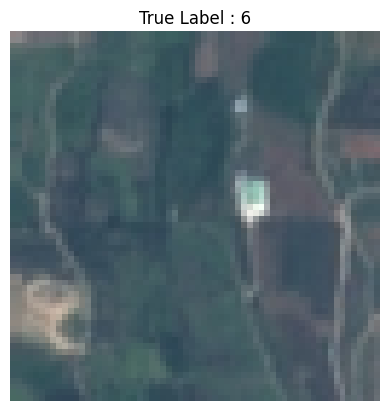

In [23]:
plt.imshow(image)
plt.title(f"True Label : {true_label}")
plt.axis("off")
plt.show()

In [24]:
image_tensor = transform(image).unsqueeze(0).to(device)

In [25]:
with torch.no_grad():
    embedding = model.encode(image_tensor)

In [26]:
with torch.no_grad():
    logits = classifier(embedding)
    predicted_label = logits.argmax(dim=1).item()
print(f"Predicted Label : {predicted_label}")

Predicted Label : 7


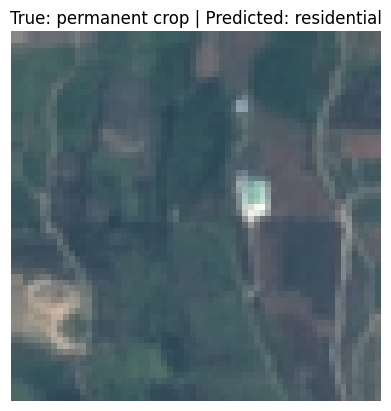

In [27]:
plt.imshow(image)
label_names = ds['train'].features['label'].names
plt.title(f"True: {label_names[true_label]} | Predicted: {label_names[predicted_label]}")
plt.axis("off")
plt.show()

In [28]:

label_names = ds["train"].features["label"].names

seen_labels = set()
samples = []

for item in ds["validation"]:
    label = item["label"]
    if label not in seen_labels:
        samples.append(item)
        seen_labels.add(label)
    if len(seen_labels) == 10:
        break

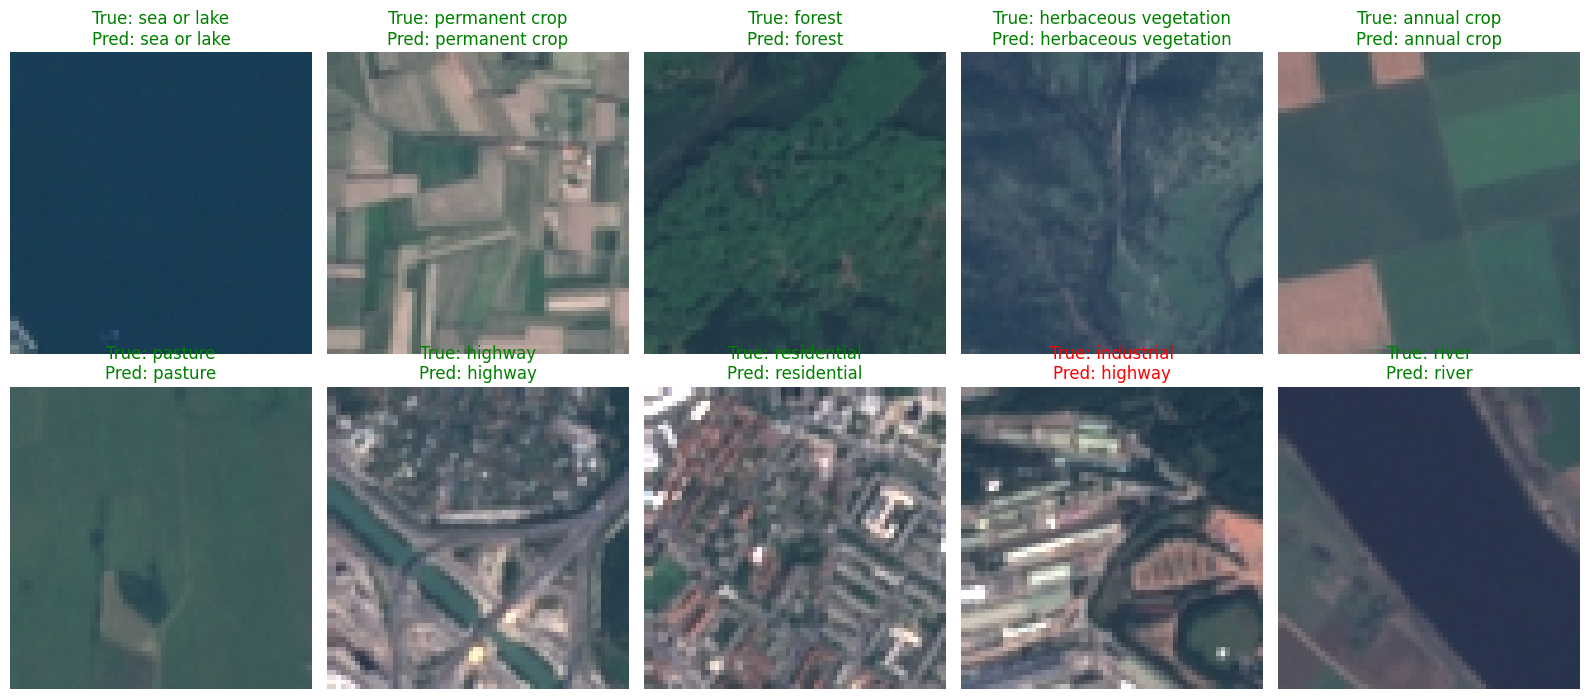

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(16, 7))
axs = axs.flatten()

for i, sample in enumerate(samples):
    image = sample["image"]
    true_label = sample["label"]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.encode(image_tensor)
        logits = classifier(features)
        pred_label = logits.argmax(dim=1).item()

    axs[i].imshow(image)
    axs[i].set_title(
        f"True: {label_names[true_label]}\nPred: {label_names[pred_label]}",
        color="green" if true_label == pred_label else "red"
    )
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.cluster import KMeans 
from tqdm import tqdm

In [45]:

sample_dataset = ds['validation']
true_labels = []

for sample in tqdm(sample_dataset):
    image = transform(sample['image']).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode(image).squeeze(0).cpu()
    features.append(embedding.numpy())
    true_labels.append(sample['label'])

  0%|          | 0/5400 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
type(features)

In [ ]:
k = 10 
kmeans = KMeans(n_clusters=k,random_state=42)
cluster_ids = kmeans.fit_predict(features)

In [43]:
import seaborn as sns 
tsne = TSNE(n_components=2,
           perplexity=30,
           random_state=42)
features_2d = tsne.fit_transform(np.array(features))

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=features_2d[:,0],
               y=features_2d[:,1],
               hue=cluster_ids,
               palette='tab10',
               s=50)
plt.title("K Means Cluster of SIMCLR Embeddings")
plt.xlabel("tsne dim 1")
plt.ylabel("tsne dim 2")
plt.legend(title="Cluster ID",
          bbox_to_anchor=(1.05,1),
          loc="upper left")
plt.tight_layout()
plt.show()

# DOWNSTREAM TASK #1 : AIRBUS DETECTION

In [9]:
import os
import ast
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.ops import misc as misc_nn_ops

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [12]:
CSV_PATH = "/kaggle/input/airbus-aircrafts-sample-dataset/annotations.csv"
IMG_DIR = "/kaggle/input/airbus-aircrafts-sample-dataset/images"

df = pd.read_csv(CSV_PATH)
df.head()

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane


In [13]:
def parse_geometry(geo_str):
    points = ast.literal_eval(geo_str)
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    return [min(xs), min(ys),max(xs),max(ys)]
df['bbox'] = df['geometry'].apply(parse_geometry)
df.head()

,id,image_id,geometry,class,bbox
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,"[135, 522, 245, 600]"
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,"[1025, 284, 1125, 384]"
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,"[1058, 1503, 1130, 1568]"
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,"[813, 1518, 885, 1604]"
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,"[594, 938, 657, 1012]"


In [31]:
def nt_xent(z: torch.Tensor, perm: torch.Tensor, tau: float) -> torch.Tensor:

    features = F.normalize(z, dim=1)
    sim = features @ features.T 
    sim.fill_diagonal_(-LARGE_NUM)
    sim /= tau
    return F.cross_entropy(sim, perm)

In [30]:
class SimCLR(nn.Module):
    def __init__(self, backbone: nn.Module, tau: float, feat_dim: int = 256):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.tau = tau
        z_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(z_dim, z_dim, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(z_dim, feat_dim, bias=False)
        )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            h = self.backbone(x)
            z = self.projection_head(h)
        return z


In [15]:
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F

In [17]:
SIMCLR_CKPT = '/kaggle/input/simclr-model-resnet50/pytorch/default/1/simclr_full_model3.pth'
backbone = resnet50()
model_simclr = SimCLR(backbone=backbone,tau=0.5)
model_simclr = torch.load(SIMCLR_CKPT)
encoder = model_simclr.backbone
encoder.fc = nn.Identity()
print("Pretrained encoder loaded successfully")

Pretrained encoder loaded successfully


/tmp/ipykernel_25/3063141321.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_simclr = torch.load(SIMCLR_CKPT)


In [23]:
return_nodes = {
    'layer1': '0',
    'layer2': '1',
    'layer3': '2',
    'layer4': '3',
}
feature_extractor = create_feature_extractor(encoder,
                                            return_nodes=return_nodes)
in_channels_list = [256, 512, 1024, 2048]
out_channels = 256
backbone_fpn = BackboneWithFPN(backbone=feature_extractor,
                               in_channels_list = in_channels_list,
                               out_channels=out_channels,
                              return_layers=return_nodes)
model = FasterRCNN(backbone_fpn,
                   num_classes=2)  # background + airplane
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Module(
        (0): Module(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [19]:
BackboneWithFPN??

Init signature:
BackboneWithFPN(
    backbone: torch.nn.modules.module.Module,
    return_layers: Dict[str, str],
    in_channels_list: List[int],
    out_channels: int,
    extra_blocks: Optional[torchvision.ops.feature_pyramid_network.ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., torch.nn.modules.module.Module]] = None,
) -> None
Source:        
class BackboneWithFPN(nn.Module):
    """
    Adds a FPN on top of a model.
    Internally, it uses torchvision.models._utils.IntermediateLayerGetter to
    extract a submodel that returns the feature maps specified in return_layers.
    The same limitations of IntermediateLayerGetter apply here.
    Args:
        backbone (nn.Module)
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).
        in

In [24]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [25]:
class AirbusDetectionDataset(Dataset):
    def __init__(self,df,img_dir,transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = df['image_id'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self,idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        img_path = os.path.join(self.img_dir,image_id)
        img = Image.open(img_path).convert('RGB')
        boxes = torch.as_tensor(records['bbox'].tolist(),dtype=torch.float32)
        labels = torch.ones((len(boxes),),dtype=torch.int64)
        target = {"boxes":boxes,
                 "labels":labels,
                 "image_id":torch.tensor([idx])}
        if self.transforms:
            img = self.transforms(img)
        return img,target

In [26]:
dataset = AirbusDetectionDataset(df, IMG_DIR, transforms=transform)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

num_epochs = 10

In [29]:

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(l for l in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10:   0%|          | 0/52 [00:00<?, ?it/s]


NotImplementedError: Module [Module] is missing the required "forward" function